In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../../../' # path to project root
sys.path.append('{}/code'.format(root_path))
sys.path.append('{}/code/core'.format(root_path))
sys.path.append('{}/code/datasets/'.format(root_path))
sys.path.insert(0,'{}/code/ptranking'.format(root_path))

from core.ranking_utils import *
from core.mallows import *
from core.ws_ranking import *
from core.ws_real_workflow import * 
from core.ws_regression import *
from datasets.imdb_tmdb_dataset import * 
from datasets.basic_clmn_dataset import * 
from core.labelling.feature_lf import *
from ptranking_wrapper import PtrankingWrapper
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import datasets_factory 
import numpy as np 
import yaml
import matplotlib.pyplot as plt
import pickle
import copy
import scipy.stats as ss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

In [2]:
dataset_name = 'imdb-tmdb'

In [3]:
df = pd.read_csv(os.path.join(root_path, 'final-results', 'outputs', dataset_name, '0810.csv')).sort_values(by='num_LFs')
df = df[df['num_LFs']!=21]
keys = ['inference_rule', 'n_train', 'num_LFs']
df = df[keys + ['test_tau']]
df_mean = df.groupby(keys).mean().reset_index()
df_std = df.groupby(keys).std().reset_index()
df = df_mean.merge(df_std, on=keys, how='left', suffixes=('_mean', '_std'))
df['test_tau_ub'] = df['test_tau_mean'] + df['test_tau_std'] 
df['test_tau_lb'] = df['test_tau_mean'] - df['test_tau_std']

In [4]:
n_train = 5000
df_true = df[df['inference_rule']=='true_label']
df_true

,inference_rule,n_train,num_LFs,test_tau_mean,test_tau_std,test_tau_ub,test_tau_lb
6,true_label,250.0,0.0,0.297780,0.004337,0.302117,0.293443
7,true_label,500.0,0.0,0.282980,0.009865,0.292845,0.273115
8,true_label,1000.0,0.0,0.263390,0.008233,0.271624,0.255157
9,true_label,1500.0,0.0,0.259960,0.007843,0.267803,0.252118
10,true_label,2000.0,0.0,0.261940,0.005233,0.267173,0.256708
11,true_label,2500.0,0.0,0.254420,0.003775,0.258195,0.250646
12,true_label,3000.0,0.0,0.253001,0.007596,0.260597,0.245404
13,true_label,4000.0,0.0,0.251041,0.006517,0.257558,0.244523
14,true_label,5000.0,0.0,0.248110,0.006394,0.254505,0.241716


In [5]:
df_ws_wk = df[df['inference_rule']=='weighted_kemeny']
df_ws_wk = df_ws_wk[df_ws_wk['n_train']==n_train]
df_ws_wk

,inference_rule,n_train,num_LFs,test_tau_mean,test_tau_std,test_tau_ub,test_tau_lb
15,weighted_kemeny,5000.0,3.0,0.26384,0.003507,0.267347,0.260333
16,weighted_kemeny,5000.0,6.0,0.25700,0.002588,0.259588,0.254413
17,weighted_kemeny,5000.0,9.0,0.25270,0.002463,0.255163,0.250237
18,weighted_kemeny,5000.0,12.0,0.25121,0.002497,0.253707,0.248713
19,weighted_kemeny,5000.0,15.0,0.25130,0.004050,0.255350,0.247250
20,weighted_kemeny,5000.0,18.0,0.24914,0.002661,0.251801,0.246479


In [6]:
df_ws_k = df[df['inference_rule']=='kemeny']
df_ws_k = df_ws_k[df_ws_k['n_train']==n_train]
df_ws_k

,inference_rule,n_train,num_LFs,test_tau_mean,test_tau_std,test_tau_ub,test_tau_lb


In [7]:
df_ws_snorkel = df[df['inference_rule']=='snorkel']
df_ws_snorkel = df_ws_snorkel[df_ws_snorkel['n_train']==n_train]
df_ws_snorkel

,inference_rule,n_train,num_LFs,test_tau_mean,test_tau_std,test_tau_ub,test_tau_lb
0,snorkel,5000.0,3.0,0.27401,0.002339,0.276349,0.271671
1,snorkel,5000.0,6.0,0.26653,0.005242,0.271772,0.261288
2,snorkel,5000.0,9.0,0.25612,0.004167,0.260287,0.251953
3,snorkel,5000.0,12.0,0.25613,0.001726,0.257856,0.254404
4,snorkel,5000.0,15.0,0.25358,0.004043,0.257623,0.249537
5,snorkel,5000.0,18.0,0.25272,0.001242,0.253962,0.251478


In [8]:
lower_n_train = 1000
upper_n_train = 2500
# df_true_small = df_true[(df_true['n_train']>=lower_n_train)&(df_true['n_train']<=upper_n_train)]
df_true_small = df_true[(df_true['n_train']==lower_n_train)|(df_true['n_train']==upper_n_train)]
df_true_small['percent'] = (df_true_small['n_train']  / n_train * 100)
df_true_small

/Users/chshin/opt/anaconda3/envs/ws-cardinality/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,inference_rule,n_train,num_LFs,test_tau_mean,test_tau_std,test_tau_ub,test_tau_lb,percent
8,true_label,1000.0,0.0,0.26339,0.008233,0.271624,0.255157,20.0
11,true_label,2500.0,0.0,0.25442,0.003775,0.258195,0.250646,50.0


In [9]:
df_true[df['n_train']==n_train]['test_tau_mean'].values[0]

/Users/chshin/opt/anaconda3/envs/ws-cardinality/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


0.24811025261878966

In [10]:
df_snorkel = df[df['inference_rule']=='snorkel']

/Users/chshin/opt/anaconda3/envs/ws-cardinality/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """
/Users/chshin/opt/anaconda3/envs/ws-cardinality/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys
/Users/chshin/opt/anaconda3/envs/ws-cardinality/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


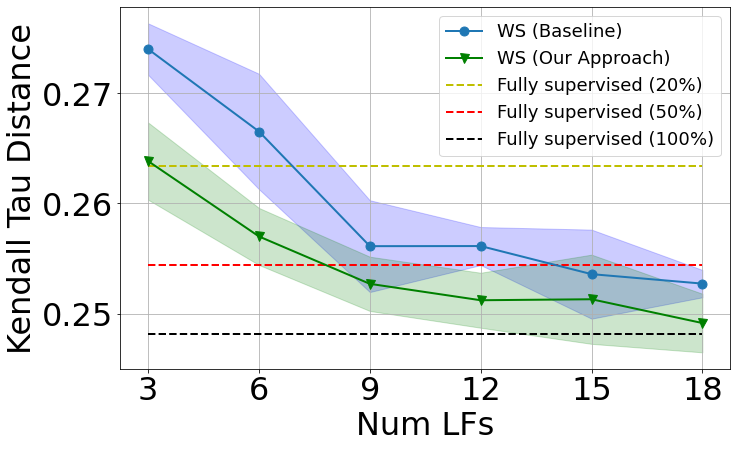

In [11]:
plt.rcParams['font.size'] = '32'

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_snorkel['num_LFs'], df_snorkel['test_tau_mean'], marker='o', linewidth=2, markerSize=9,
        label='WS (Baseline)')
ax.plot(df_ws_wk['num_LFs'], df_ws_wk['test_tau_mean'], color='g', marker='v', linewidth=2, markerSize=9,
        label='WS (Our Approach)')
ax.fill_between(df_ws_snorkel['num_LFs'], df_ws_snorkel['test_tau_lb'], df_ws_snorkel['test_tau_ub'], color='b',
                alpha=0.2)
ax.fill_between(df_ws_wk['num_LFs'], df_ws_wk['test_tau_lb'], df_ws_wk['test_tau_ub'], color='g', alpha=0.2)

colors = ['y', 'r', 'k', 'c', 'm']
for i, sample_percent in enumerate(sorted(df_true_small['percent'])):
    val = df_true_small[df_true_small['percent']==sample_percent]['test_tau_mean']
    ax.hlines(y=val, linewidth=2, xmin=3, xmax=18, color=colors[i],
            linestyles='--', label=f'Fully supervised ({int(sample_percent)}%)')
    
ax.hlines(y=df_true[df['n_train']==n_train]['test_tau_mean'].values[0], linewidth=2, 
          xmin=3, xmax=18, color='k', linestyles='--', label='Fully supervised (100%)')
ax.grid()
ax.set_xticks(range(3,21,3)) 
ax.legend(fontsize=18)
ax.set(xlabel='Num LFs', ylabel='Kendall Tau Distance')
plt.tight_layout()
plt.savefig(os.path.join(root_path, 'final-results',
                         'plots',
                         dataset_name,
                         f'{dataset_name}-full-rankings-realData-syntheticLFs-rebuttal-updated.pdf'),dpi=500)